In [390]:
import matplotlib.pyplot as plt
import json
from typing import Dict, Any

import matplotlib
import colorsys
import numpy as np
# load json data

def load_json_file(file_path: str) -> Dict[str, Any]:
    """Load a JSON file and return its content."""
    with open(file_path, "r", encoding="utf-8") as json_file:
        return json.load(json_file)


def extract_base_name(filename):
    return filename.split("_")[0]


def get_tinted_color(color, version_index):
    """Increase the lightness of the color as the version index increases."""
    # Convert the RGB color to HSL
    h, l, s = colorsys.rgb_to_hls(*color[:3])

    # Increase the lightness as the version_index increases
    l += min(1, 0.05 * version_index)
    
    # Convert the HSL color back to RGB
    return colorsys.hls_to_rgb(h, l, s)

In [391]:
data = load_json_file("similarity_scores.json")

organized_data = {}
for filename, details in data.items():
    base_name = extract_base_name(filename)
    if base_name not in organized_data:
        organized_data[base_name] = []
    organized_data[base_name].append({
        'cosine_similarity': float(details['cosine_similarity']),
        'levenshtein_distance': details['levenshtein_distance'],
        'tfidf_similarity': float(details['tfidf_similarity']),
        'jaccard_similarity': float(details['jaccard_similarity']),
        'word2vec_similarity': float(details['word2vec_similarity']),
        'ast_cosine_similarity': float(details['ast_cosine_similarity']),
        'ast_levenstein_distance': details['ast_levenstein_distance'],
        'ast_tfidf_similarity': float(details['ast_tfidf_similarity']),
        'ast_word2vec_similarity': float(details['ast_word2vec_similarity'])
    })

similarity_types = list(organized_data[next(iter(organized_data))][0].keys())

color_map = matplotlib.colormaps.get_cmap('tab10')

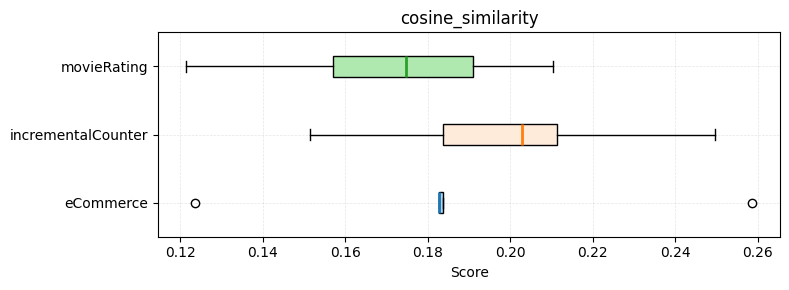

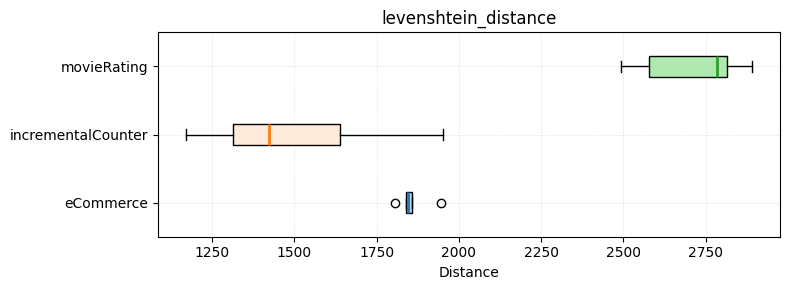

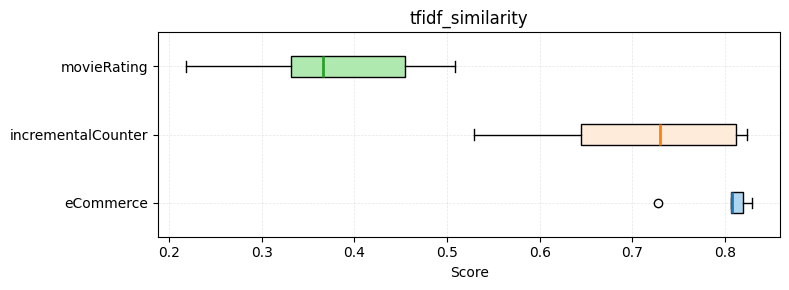

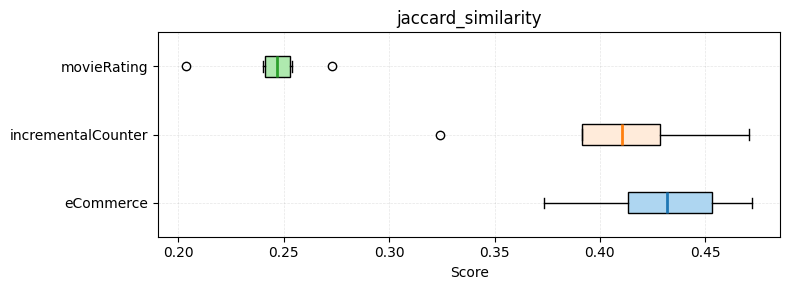

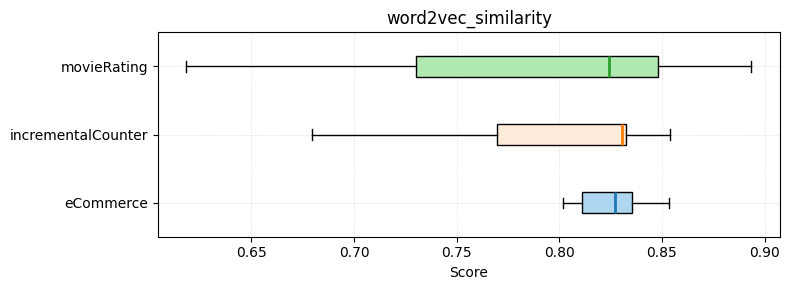

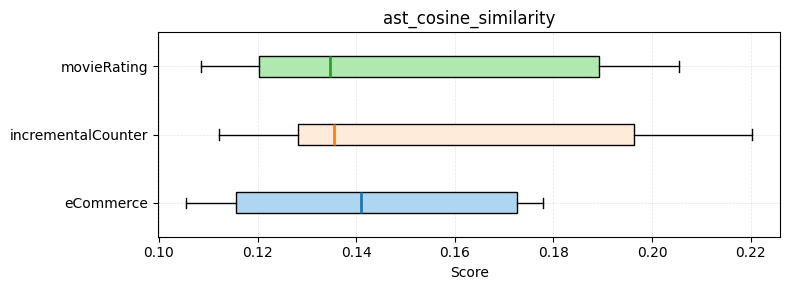

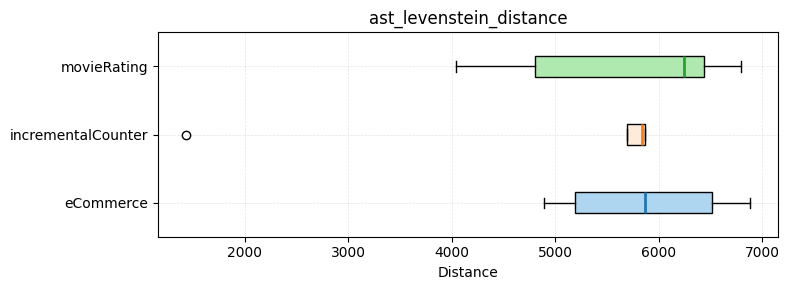

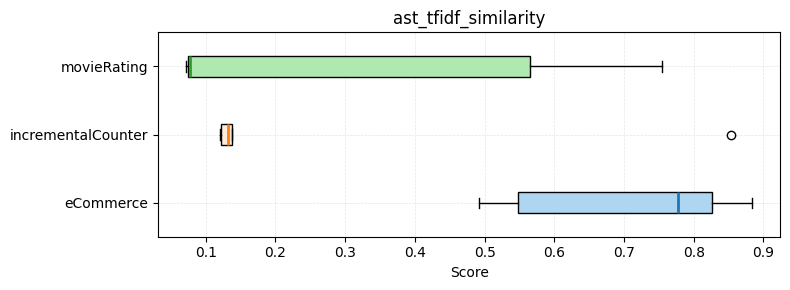

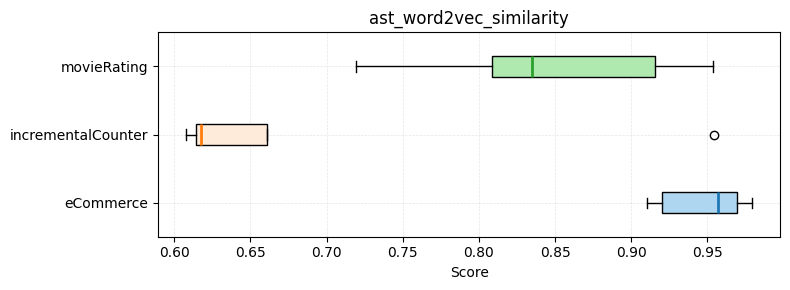

In [392]:
for i, sim_type in enumerate(similarity_types):
    boxplot_data = []
    for files in organized_data.values():
        boxplot_data.append([file[sim_type] for file in files])

    # Create a new figure for each similarity type
    fig, ax = plt.subplots(figsize=(8, len(organized_data.values())))
    bp = ax.boxplot(boxplot_data, labels=organized_data.keys(), vert=False, zorder=2, patch_artist=True)
    ax.set_title(sim_type)
    ax.set_xlabel('Score' if 'distance' not in sim_type.lower() else 'Distance')

    # Set the background color of the boxes to a light color
    for j, patch in enumerate(bp['boxes']):
        patch.set_facecolor(get_tinted_color(color_map(j), 8))

    for j, median in enumerate(bp['medians']):
        median.set(color=color_map(j), linewidth=2)


    ax.grid(color='black', linestyle='dashed', linewidth=0.5, alpha=0.1, zorder=1, )

    plt.tight_layout()
    plt.show()

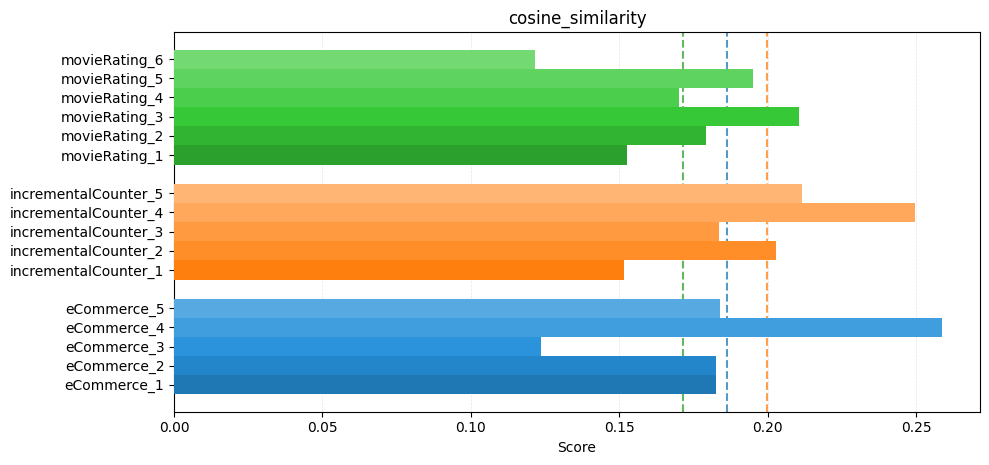

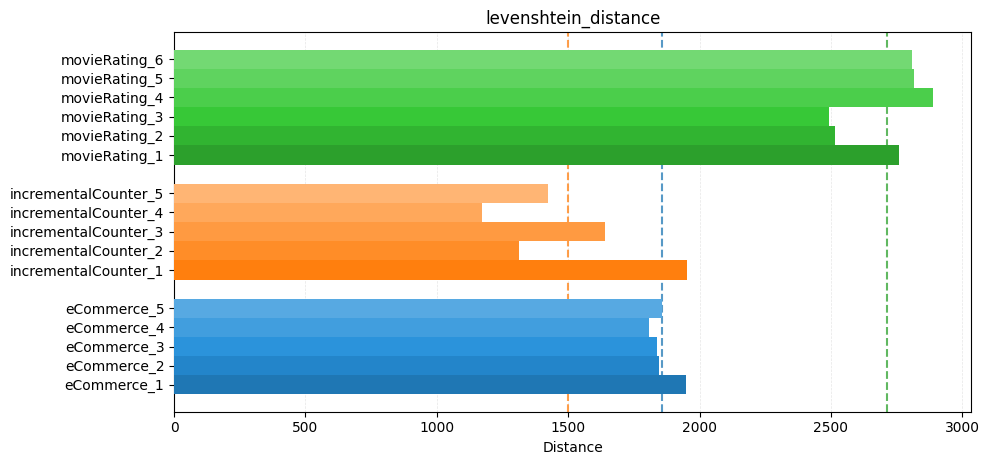

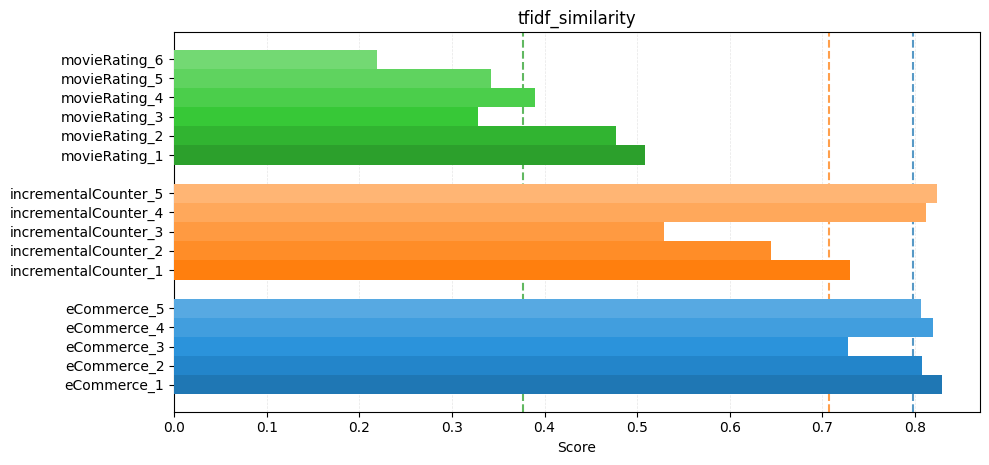

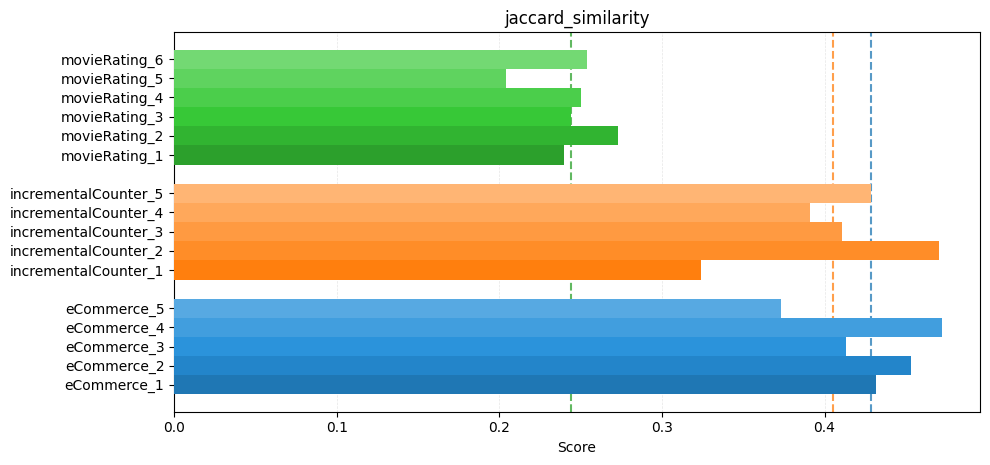

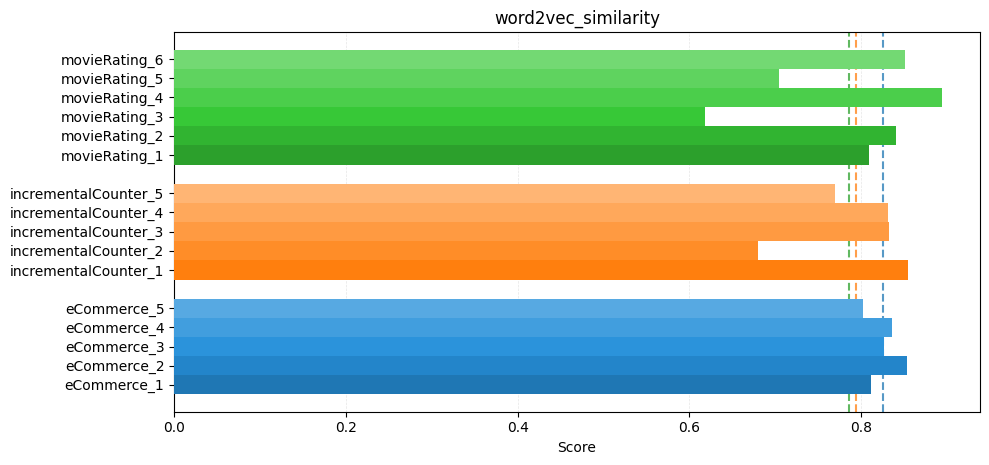

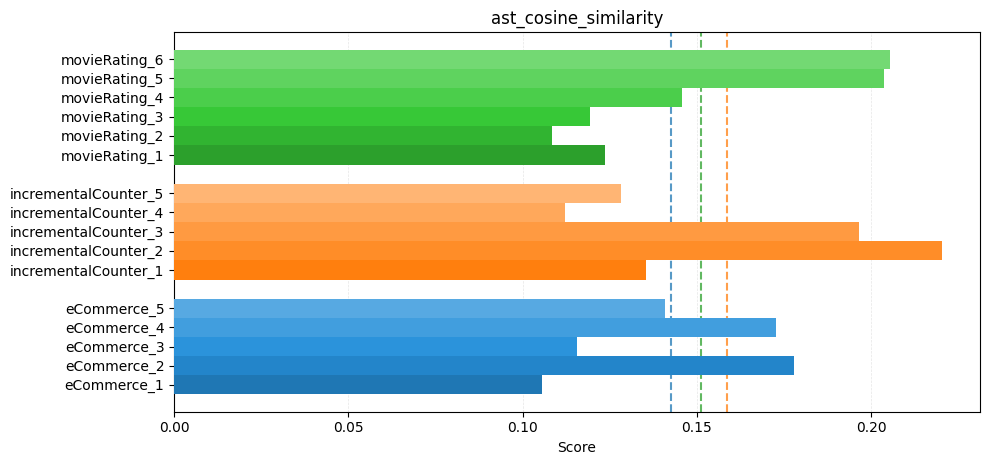

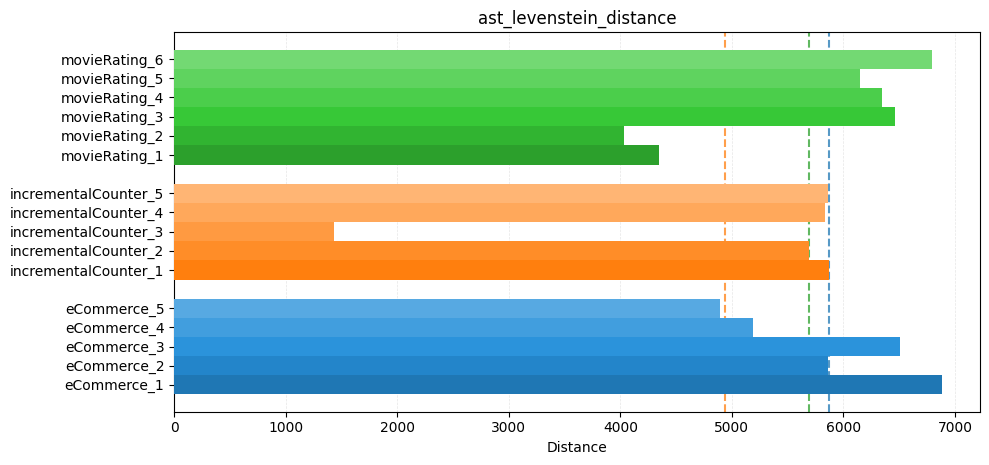

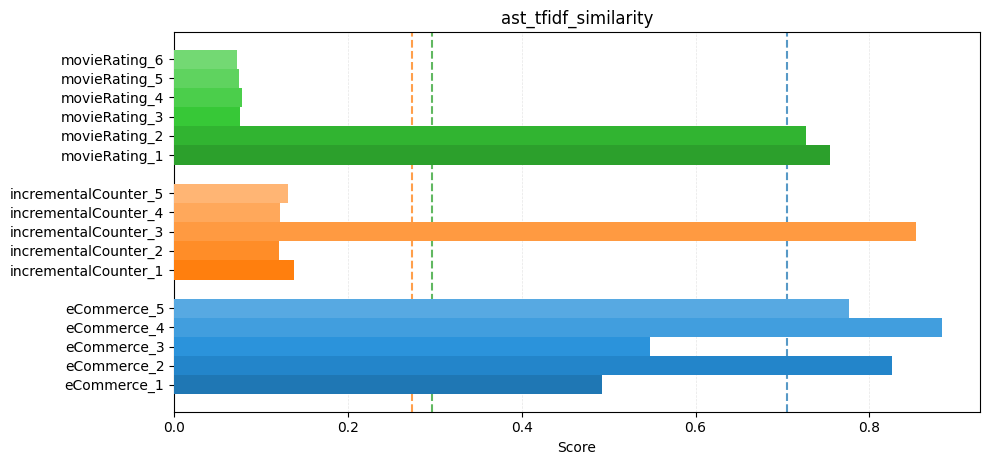

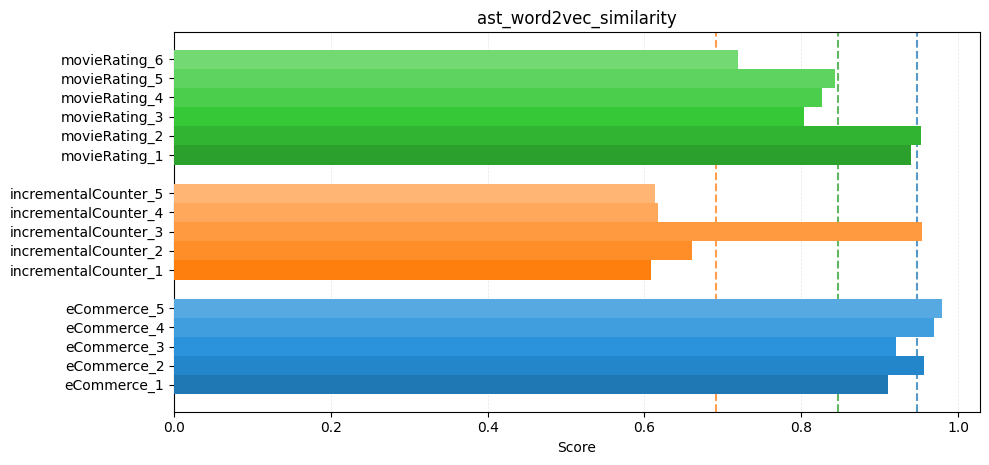

In [393]:
bar_amount = len(data.items()) + len(organized_data.items())
total_height = 1
bar_height = 1 / bar_amount

for i, sim_type in enumerate(similarity_types):
    fig, ax = plt.subplots(figsize=(10, bar_amount/4))

    # Initialize the position of the first bar
    current_bar_position = 0

    y_ticks = []
    y_tick_labels = []

    for j, (file, scores) in enumerate(organized_data.items()):
        scores_for_type = [score[sim_type] for score in scores]

        color = color_map(j)

        # Create a bar for each file version
        for version_index, score in enumerate(scores_for_type):

            # Create the bar with a higher zorder
            bar = ax.barh(
                current_bar_position + version_index * bar_height, 
                score, 
                height=bar_height, 
                color=get_tinted_color(color_map(j), version_index), 
                label=f'{file} Version {version_index+1}', 
                zorder=3)

            # Add the y position and label for this bar to the lists
            y_ticks.append(current_bar_position + version_index * bar_height)
            y_tick_labels.append(f'{file}_{version_index+1}')

        # Calculate the mean score for this file type
        mean_score = np.mean(scores_for_type)

        # Draw a vertical line at the mean score
        ax.axvline(mean_score, ymin=0, ymax=1, color=color, alpha= 0.75, linestyle='dashed', zorder=2, label=f'{file} Mean Score')

        # Update the position for the next file
        current_bar_position += len(scores_for_type) * bar_height + bar_height # Add a small space between each file

    ax.set_title(sim_type)
    ax.set_xlabel('Score' if 'distance' not in sim_type.lower() else 'Distance')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)

    # Add vertical lines at each x-tick with a lower zorder
    ax.grid(axis='x', color='black', linestyle='dashed', linewidth=0.5, alpha=0.1, zorder=1, )


    plt.tight_layout()
    plt.show()